In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

from imageio import imread, imsave
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.filters import sobel, gaussian
from skimage.measure import label, regionprops
from skimage.morphology import convex_hull_image

# Общий план работы

1. Определить главные точки арки

2. Определить главные точки красной коробки

3. По главным точкам сделать вывод о том, пройдет ли коробка под арку


# 1. Главыне точки арки
Главные точки арки, показаны на картинке


<img src="https://github.com/atani20/signal-cv/blob/main//explain/explain1.jpg" alt="drawing" width="400"/>

Для их определения воспользуемся алгоритмом распознавания особых точек.
1. В файле ... хранятся несколько заранее подготовленных шаблонов арки, где выделены нужные точки, а так же посчитаны их дескрипторы
2. По входной картинке с помощью детектора ORB определяются особые точки их десрипторы
3. Дескрипторы точек сопоставлются с десрипторомами точек на шаблоне
4. Находится гомеоморфное преобразование точек шаблона в точки на изображении
5. Так прогоняется по всем шаблонам и выбирается лучший результат

После выполнения данного шага у нас имеются оординаты точек, отмеченных на рисунке

In [2]:
path_to_image = 'test1.JPG'

In [3]:
# подготовка темплейтов
path_to_templates = 'templates.pkl'
import pickle
with open(path_to_templates, 'rb') as fp:
    data = pickle.load(fp)
    
for elem in data:
    collect_kp = []
    point = data[elem]['kp']
    pt, size, angle, response, octave, class_id = data[elem]['kp']
    collect_kp = [cv2.KeyPoint(x=pt[i][0],y=pt[i][1],_size=size[i], _angle=angle[i], 
                            _response=response[i], _octave=octave[i], _class_id=class_id[i])
                 for i in range(len(pt))]
    data[elem]['kp'] = collect_kp

In [4]:
# подготовка данных изображения

# считываем изображение 
img = cv2.imread(path_to_image)
img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# находим особые точки и их дескрипторы
orb = cv2.ORB_create()
kp, des = orb.detectAndCompute(img_gray, None)

In [5]:
best_template = ''
min_distance = 10000

bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
for elem in data:
    point_template = data[elem]['points']
    key_point_template = data[elem]['kp']
    des_template = data[elem]['des']
    
    # Match descriptors.
    matches = bf.match(des_template, des)

    # Sort them in the order of their distance.
    matches = sorted(matches, key = lambda x:x.distance)
    
    distances = [elem.distance for elem in matches]

    avg_dist = sum(distances) / len(distances)
    if avg_dist < min_distance:
        min_distance = avg_dist
        best_template = elem
    

In [6]:
point_template = data[best_template]['points']
key_point_template = data[best_template]['kp']
des_template = data[best_template]['des']

# Match descriptors.
matches = bf.match(des_template, des)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

In [7]:
src = np.float32([ key_point_template[m.queryIdx].pt for m in matches ]).reshape(-1,1,2)
dst = np.float32([ kp[m.trainIdx].pt for m in matches ]).reshape(-1,1,2)


points1 = np.float32(point_template[0]).reshape(-1, 1, 2)
points2 = np.float32(point_template[1]).reshape(-1, 1, 2)
points3 = np.float32(point_template[2]).reshape(-1, 1, 2)

# гомография и перспективные искажения
M, status = cv2.findHomography(src, dst, cv2.RANSAC, 2)
transform1 = cv2.perspectiveTransform(points1, M)
transform2 = cv2.perspectiveTransform(points2, M)
transform3 = cv2.perspectiveTransform(points3, M)
size_x = max(transform1[:, 0, 0]) - min(transform1[:, 0, 0])
size_y = max(transform1[:, 0, 1]) - min(transform1[:, 0, 1])

In [8]:
# найденные особые точки
a = transform1[0][0]
b = transform1[1][0]
c = transform1[2][0]
d = transform1[3][0]

a1 = transform2[0][0]
b1 = transform2[1][0]
c1 = transform2[2][0]
d1 = transform2[3][0]

e = transform3[1][0]
g = transform3[2][0]

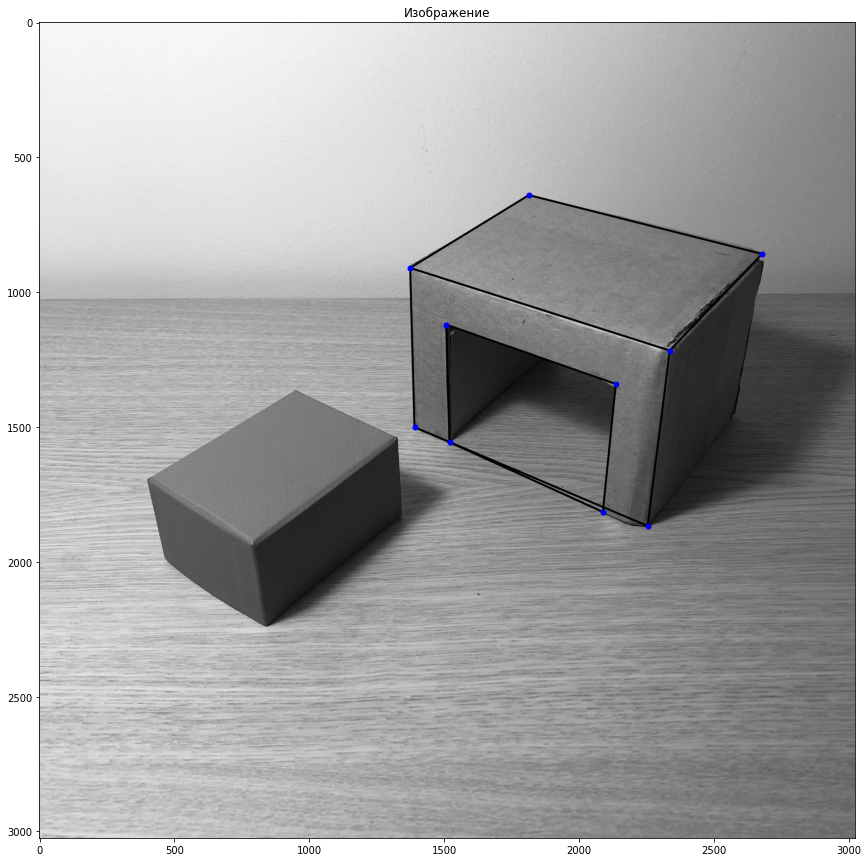

In [9]:
# изобразим полученное
plt.subplots(figsize=(15, 15))

cv2.polylines(img_gray, [np.int32(transform1)], True, 0,5, cv2.LINE_AA)
cv2.polylines(img_gray, [np.int32(transform2)], True, 0,5, cv2.LINE_AA)
cv2.polylines(img_gray, [np.int32(transform3)], True, 0,5, cv2.LINE_AA)
plt.title('Изображение')
plt.imshow(img_gray, cmap='gray')
plt.plot([a[0], b[0], c[0], d[0], a1[0], b1[0], c1[0], d1[0], e[0], g[0]], 
           [a[1], b[1], c[1], d[1], a1[1], b1[1], c1[1], d1[1], e[1], g[1]], 'ob', markersize=5)
plt.show()

# 2 Главные точки коробки
Для коробки нам нужно знать по две главные точки для высоты и ширины.
На каждой картинке показаны пары точек, координаты которых нам нужно узнать (достаточно только одной пары точек)


<img src="./explain/explain2.jpg" alt="drawing" width="400"/>
<img src="./explain/explain3.jpg" alt="drawing" width="400"/>

Для определения этих точек воспользуемся следующим алгоритмом
1. На исходном изображении находим границы методом Canny
2. Находим область, где есть только красная коробка
    1. Сначала область маски подбирается по цветовым характеристикам изображения
    2. Из маски удаляется та облась, которая принадлежит арке (найденная в прошлом пункте)
    3. Применяются бинарные операции
    4. На полученном изображении область с наибольшим значением площади является областью, где содержится коробка
    5. Делаем полученную область выпуклой и расширяем ее границы (это делается, чтобы не возникло трудностей с шагом 3)
3. Берем только те границы, которые попадают в маску красной коробки
4. По границам находим линии алгоритмом Хаффа
5. Раздаляем линии на три категории в зависимости от их угла наклона: верхние, левые правые. Разные категории показаны разным цветом:
    <img src="./explain/explain4.jpg" alt="drawing" width="400"/>
6. Далее по пересечению этих линий находим нужные пары особых точек. Линии могут распознаться не все, поэтому есть вариантивность в нахождении пар точек

In [10]:
# нахождение границ всего изображения
def get_edges(img):
    rgb_img = rgb2gray(img)

    rgb_img_blur = gaussian(rgb_img, sigma=2.5, multichannel=True)
    img_edges = canny(rgb_img_blur, sigma=3, low_threshold=0.0001)

    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title("Source")
    ax[1].set_title("Edges")
    ax[0].imshow(img, cmap="gray")
    ax[1].imshow(img_edges, cmap="gray")
    plt.show()

    return img_edges

In [11]:
# расширение маски
def expand_mask(mask, rad=13):
    new_mask = np.zeros(mask.shape, dtype=bool)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[0]):
            if mask[i,j]:
                for i1 in range(max(i - rad//2, 0), min(i + rad //2, mask.shape[0])):
                    for j1 in range(max(0, j - rad//2), min(j + rad //2, mask.shape[0])):
                        new_mask[i1,j1] = True
    plt.imshow(new_mask, cmap='gray')
    return new_mask   
                

In [12]:
from skimage.morphology import binary_opening, binary_closing

# нахождение области, в которой находится только красная коробка

def get_box_mask(img):
    image_gray = rgb2gray(img)
    channel = img[..., 0]

    mask = (-(image_gray - channel) <= (70))  # было подобрано исходя из цветового анализа изображения
    mask = np.uint8(mask)*255
    
    cv2.fillPoly(mask, [np.int32(transform1)], 0)
    cv2.fillPoly(mask, [np.int32(transform2)], 0)
    cv2.fillPoly(mask, [np.int32(transform3)], 0)
#     f, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].set_title("Source")
#     ax[1].set_title("Box region")
#     ax[0].imshow(img, cmap="gray")
#     ax[1].imshow(mask, cmap="gray")
#     plt.show()
    mask = binary_closing(mask, selem=np.ones((15, 15)))
#     f, ax = plt.subplots(1, 2, figsize=(10, 5))
#     ax[0].set_title("Source")
#     ax[1].set_title("Box region")
#     ax[0].imshow(img, cmap="gray")
#     ax[1].imshow(mask, cmap="gray")
#     plt.show()
    labels = label(mask) # разбиение маски на компоненты связности
    props = regionprops(labels) # нахождение свойств каждой области (положение центра, площадь, bbox, интервал интенсивностей и т.д.)
    areas = [prop.area for prop in props] # нас интересуют площади компонент связности
    areas = np.array(areas)
    largest_comp_id = np.array(areas).argmax()# находим номер компоненты с максимальной площадью
    mask = labels == (largest_comp_id + 1)
    
    mask = convex_hull_image(mask)
    mask = expand_mask(mask, 5)
    
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].set_title("Source")
    ax[1].set_title("Box region")
    ax[0].imshow(img, cmap="gray")
    ax[1].imshow(mask, cmap="gray")
    plt.show()
    return mask

In [13]:
from skimage.transform import (hough_line, hough_line_peaks,
                               probabilistic_hough_line)
from skimage.feature import canny

from matplotlib import cm
# преобразования Хаффа
def show_hough_transform(edge):
    image = edge
    h, theta, d = hough_line(edge)  # вычисляем преобразование Хафа от границ изображения

    fig, ax = plt.subplots(1, 3, figsize=(15, 6))

    ax[0].imshow(image, cmap=cm.gray)
    ax[0].set_title('Input image')
    ax[0].set_axis_off()

    ax[1].imshow(np.log(1 + h),
                 extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]), d[-1], d[0]],
                 cmap='gray', aspect=1/20)
    ax[1].set_title('Hough transform')
    ax[1].set_xlabel('Angles (degrees)')
    ax[1].set_ylabel('Distance (pixels)')

    ax[2].imshow(image, cmap=cm.gray)
    for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax[2].plot((0, image.shape[1]), (y0, y1), '-r')
    ax[2].set_xlim((0, image.shape[1]))
    ax[2].set_ylim((image.shape[0], 0))
    ax[2].set_axis_off()
    ax[2].set_title('Detected lines')
    plt.tight_layout()
    return hough_line_peaks(h, theta, d)
    

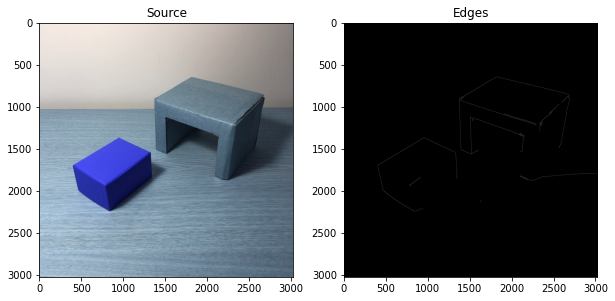

In [14]:
img = cv2.imread(path_to_image)
edge = get_edges(img)
# примечание: границы тонкие, еле заметны

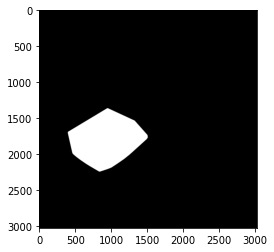

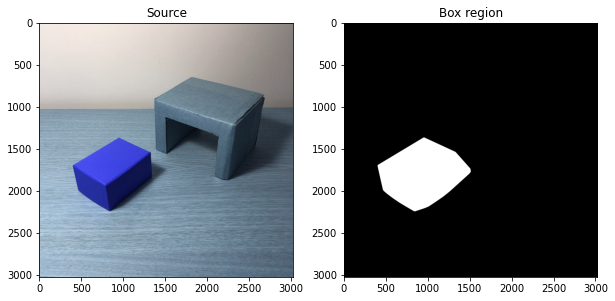

In [15]:
box_mask = get_box_mask(img)

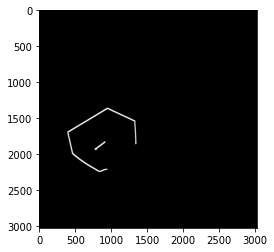

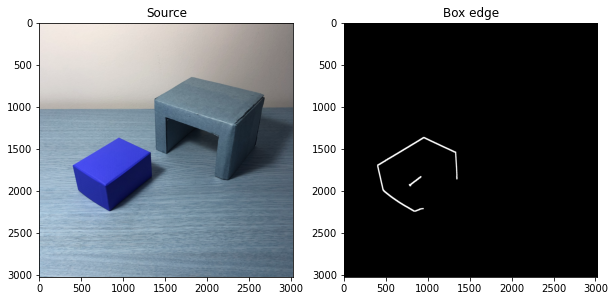

In [16]:
# теперь оставим только границу куба
box_edge = box_mask * edge 
box_edge = expand_mask(box_edge, 15)
f, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title("Source")
ax[1].set_title("Box edge")
ax[0].imshow(img, cmap="gray")
ax[1].imshow(box_edge, cmap="gray")
# plt.show()

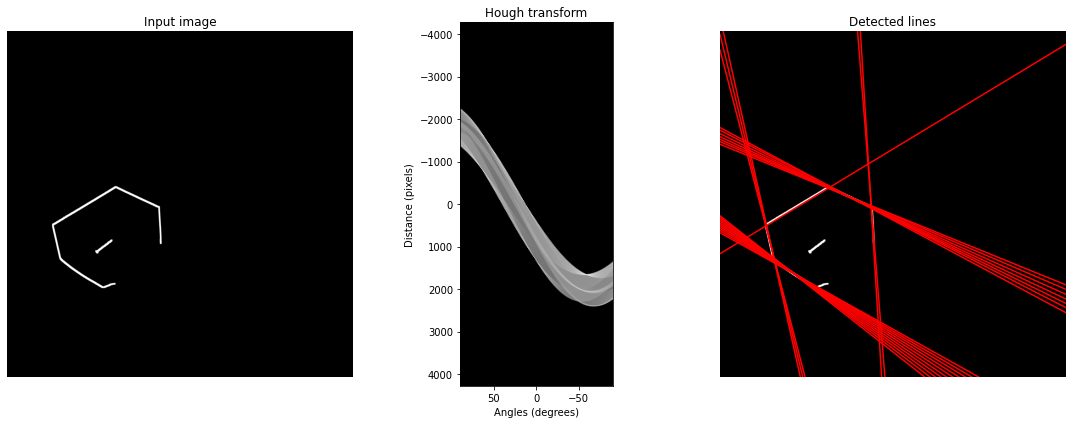

In [17]:
# c помощью преобразований Хаффа выделяем линии кубика
hough_line_peaks_box = show_hough_transform(box_edge)

In [18]:
# все линии имеют три направления - 'вертикальные', 'левые', 'правые'
# выделим такие линии, а так же удалим похожие

_, angles, dists =  hough_line_peaks_box

#3 класса
straight = []
left = []
right = []
for angle, dist in zip(angles, dists):
    if abs(angle) <= 0.3: # вертикальная линия практически не наклонена
        straight.append((angle, dist))
    elif angle > 0.3: # у левой линии положительный угол наклона
        left.append((angle, dist))
    else: # у правой линии отрицательный угол наклона
        right.append((angle, dist))

In [19]:
import random

# пробегааемся по всем линия и удаляем похожие
def remove_similar_lines_with_coeg(lines, coef):
    result_line = []
    indxs = []
    for i in range(len(lines)):
        if i in indxs:
            continue
        a1, d1 = lines[i]
        similar_line = [lines[i]]
        indxs.append(i)
        for j in range(i + 1, len(lines)):
            if j in indxs:
                continue
            a2, d2 = lines[j]
            if abs(d1-d2) < coef:
                similar_line.append(lines[j])
                indxs.append(j)
        result_line.append(random.choice(similar_line))
    return sorted(result_line, key=lambda x: x[1])

def remove_similar_lines(lines):
    coef = 60
    lines = remove_similar_lines_with_coeg(lines, coef)
    while len(lines) > 3:
        coef += 5
        lines = remove_similar_lines_with_coeg(lines, coef)
    return lines

straight = remove_similar_lines(straight)
left = remove_similar_lines(left)
right = remove_similar_lines(right)

<function matplotlib.pyplot.show(close=None, block=None)>

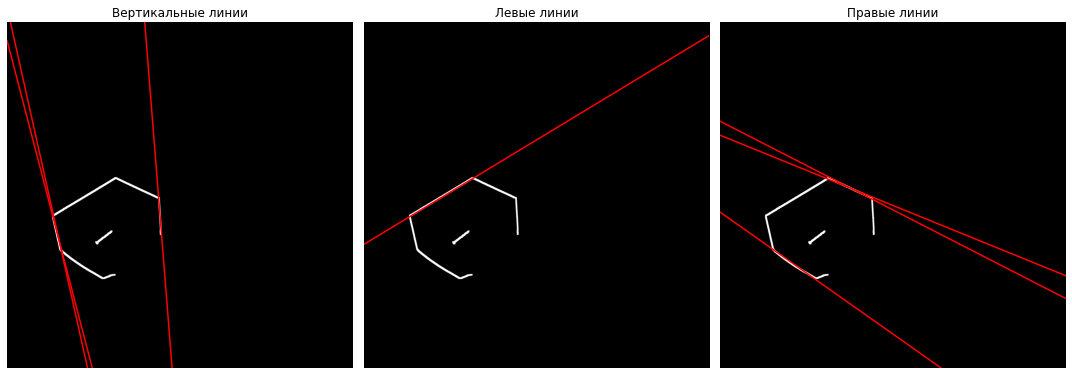

In [20]:
# после преобразования линий получаем следующее
image = box_edge
def draw_line(image, lines, ax, name):
    ax.imshow(image, cmap=cm.gray)
    for angle, dist in lines:
        y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
        y1 = (dist - image.shape[1] * np.cos(angle)) / np.sin(angle)
        ax.plot((0, image.shape[1]), (y0, y1), '-r')
    ax.set_xlim((0, image.shape[1]))
    ax.set_ylim((image.shape[0], 0))
    ax.set_axis_off()
    ax.set_title(name)


fig, ax = plt.subplots(1, 3, figsize=(15, 6))
draw_line(image, straight, ax[0], 'Вертикальные линии')
draw_line(image, left, ax[1], 'Левые линии')
draw_line(image, right, ax[2], 'Правые линии')
plt.tight_layout()
plt.show

Не везде нашлись по три линии, где-то одна, где-то две, где-то три

Для того, чтобы определить пройдет ли нужно найти точки высоты и точки ширины

In [21]:
# устанавилаем порядок между линиями
def get_3_line(lines):
    if len(lines) == 1:
        return lines[0], None, None
    if len(lines) == 2:
        return lines[0], None, lines[1]
    return lines[0], lines[1], lines[2]

In [22]:
from math import sin, cos, tan

# некоторые преобазования С для поиска пересечения линий
def polar_line_to_decart(angle, dist):
    k = tan(angle)
    b = dist / cos(angle)
    return -k, b


def intersect_line_polar(line1, line2):
    if line1 is None or line2 is None:
        return None
    k1, b1 = polar_line_to_decart(*line1)
    k2, b2 = polar_line_to_decart(*line2)
    x = (b2 - b1) / (k1 - k2)
    y = k1 * x + b1
    return x, y

Далее идут функции поиска пары точек h и пары точек w.

В функциях используется названия точек и линий. Для того, чтобы читающему было понятно, что к чему, приведем пояснение с помощью рисунка: 

<img src="./explain/explain5.jpg" alt="drawing" width="400"/>

Неоторые точки ищутся разными способами, поскольку не все линии могут быть определены на изображении

In [23]:
def height_points(straight, left, right):
    s1, s2, s3 = get_3_line(straight)
    l1, l2, l3 = get_3_line(left)
    r1, r2, r3 = get_3_line(right)
        # точки высоты
    a = intersect_line_polar(s1, l1)
    
    if a is None:
        a = intersect_line_polar(s1, r2)  
    if a is None:
        a = intersect_line_polar(l1, r2)  
    a1 = intersect_line_polar(s1, r1)    
    h = [a, a1]
    if None not in h:
        print('a, a1')
        return np.array(h)
    
    d = intersect_line_polar(r2, l2)  
    if d is None:
        d = intersect_line_polar(r2, s2)
    if d is None:
        d = intersect_line_polar(l2, s2)  
        
    d1 = intersect_line_polar(r1, l3)  
    if d1 is None:
        d1 = intersect_line_polar(r1, s2)
    if d1 is None:
        d1 = intersect_line_polar(l3, s2)     
        
    h = [d, d1]
    if None not in h:
        print('d, d1')
        return np.array(h)
    
    c = intersect_line_polar(r3, l2)  
    if c is None:
        c = intersect_line_polar(r3, s3)
    if c is None:
        c = intersect_line_polar(l2, s2)  
        
    c1 = intersect_line_polar(l3, s3)  
        
    h = [c, c1]
    if None not in h:
        print('c, c1')
        return np.array(h)  
    
    return None


In [24]:

def get_width_points(straight, left, right):
    s1, s2, s3 = get_3_line(straight)
    l1, l2, l3 = get_3_line(left)
    r1, r2, r3 = get_3_line(right)
        # точки высоты
        
    a1 = intersect_line_polar(s1, r1) 
    c1 = intersect_line_polar(l3, s3)  
    w = [c1, a1]
    if None not in w:
        print('c1, a1')
        return np.array(w), False
    
    a = intersect_line_polar(s1, l1)
    if a is None:
        a = intersect_line_polar(s1, r2)  
    if a is None:
        a = intersect_line_polar(l1, r2) 
    
    c = intersect_line_polar(r3, l2)  
    if c is None:
        c = intersect_line_polar(r3, s3)
    if c is None:
        c = intersect_line_polar(l2, s2)     
    w = [c, a]
    if None not in w:
        print('c, a')
        return np.array(w), True     
        
    
    return None, None    

In [25]:
h = height_points(straight, left, right)
w, flag = get_width_points(straight, left, right)

a, a1
c, a


Посмотрим, какие точки нашел алгоритм

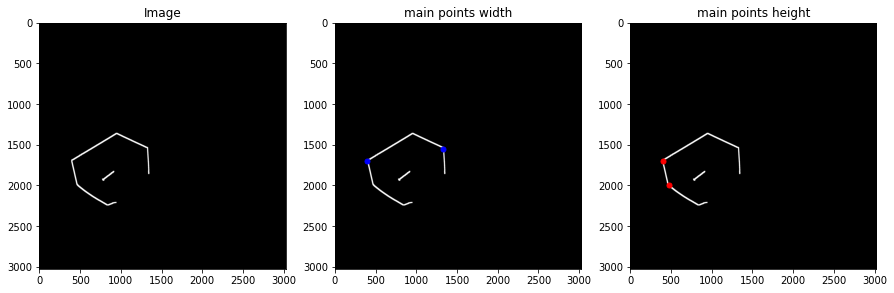

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
ax[0].set_title('Image')
ax[0].imshow(image, cmap='gray')


ax[1].set_title('main points width')
ax[1].imshow(image, cmap='gray')
ax[1].plot(w[:, 1], w[:, 0], 'ob', markersize=5)

ax[2].set_title('main points height')
ax[2].imshow(image, cmap='gray')
ax[2].plot(h[:, 1], h[:, 0], 'or', markersize=5)

Теперь у нас есть все, чтобы определеить пройдет ли коробка

# 3. Определение пройдет ли коробка под арку

Условие пролезания коробки под арку: коробка пролезет под арку, если проекция коробки на плоскость, которая содержит отверстие арки, не перекрывает область отверстия арки.

Проекция коробки на эту плоскость есть четырехугольник. Покажем, как это делать

1. Определение фокусов коробки
<img src="./explain/explain6.jpg" alt="drawing" width="400"/>

2. Определение, пройдет ли коробка по высоте:
    Находим точку p2, с помощью построений, показанных на рисунке
    <img src="./explain/explain7.jpg" alt="drawing" width="400"/>
    
    Если p2 лежит выше, чем прямая b1c1, то коробка не пройдет по высоте. Иначе - пройдет
    
2. Определение, пройдет ли коробка по ширине:
    Находим точки p1, p2, с помощью построений, показанных на рисунке
    <img src="./explain/explain8.jpg" alt="drawing" width="400"/>
    
    Если расстояние между p1 и p2 больше расстояния между a1 и d1, то коробка не пройдет по ширине
    
    
  

In [27]:
from math import sqrt
# некоторые вспомагательные функции

def get_l2(p1, p2):
    return sqrt((p1[0]- p2[0])**2 + (p1[1] - p2[1])**2)

def two_point_to_line(p1, p2):
    k = (p1[1] - p2[1]) / (p1[0] - p2[0])
    b = p1[1] - k * p1[0]
    return k, b

def intersect_line_decart(line1, line2):
    k1, b1 = line1
    k2, b2 = line2
    x = (b2 - b1) / (k1 - k2)
    y = k1*x+b1
    return x, y

In [28]:
h1 = [h[0][1], h[0][0]]
h2 = [h[1][1], h[1][0]]

w1 = [w[0][1], w[0][0]]
w2 = [w[1][1], w[1][0]]
if flag:
    dist = get_l2(h1, h2)
    w1[1] += dist
    w2[1] += dist




a = transform1[0][0]
b = transform1[1][0]
c = transform1[2][0]
d = transform1[3][0]

a1 = transform2[0][0]
b1 = transform2[1][0]
c1 = transform2[2][0]
d1 = transform2[3][0]

e = transform3[1][0]
g = transform3[2][0]

<function matplotlib.pyplot.show(close=None, block=None)>

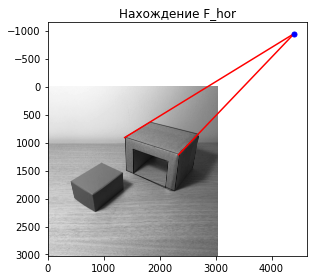

In [29]:
line1 = two_point_to_line(b, e)
line2 = two_point_to_line(c, g)
F_hor = intersect_line_decart(line1, line2)

plt.imshow(img_gray, cmap='gray')
plt.plot( [F_hor[0], b[0]],[F_hor[1], b[1]], 'r')
plt.plot( [F_hor[0], c[0]] , [F_hor[1], c[1]],'r')

plt.title('Нахождение F_hor')
plt.plot(  F_hor[0], F_hor[1],'ob', markersize=5)
plt.tight_layout()
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

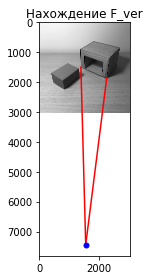

In [30]:
line1 = two_point_to_line(a, b)
line2 = two_point_to_line(c, d)
F_ver = intersect_line_decart(line1, line2)

plt.imshow(img_gray, cmap='gray')
plt.plot( [F_ver[0], a[0]],[F_ver[1], a[1]], 'r')
plt.plot( [F_ver[0], d[0]] , [F_ver[1], d[1]],'r')

plt.plot(  F_ver[0], F_ver[1],'ob', markersize=5)
plt.title('Нахождение F_ver')
plt.tight_layout()
plt.show

YES. По высоте пройдет


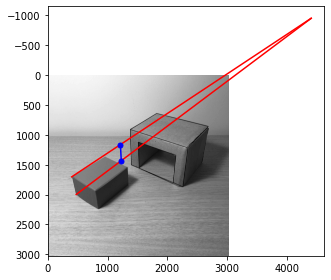

In [31]:
# проверка, пройдет ли короба по высоте
line1 = two_point_to_line(h2, F_hor)
line2 = two_point_to_line(a, d)
p1 = intersect_line_decart(line1, line2)

line3 = two_point_to_line(p1, F_ver)
line4 = two_point_to_line(h1, F_hor)
p2 = intersect_line_decart(line3, line4)

k, b = two_point_to_line(b1, c1)
x, y = p2[0], p2[1]
if k*x + b > y:
    print('NO. Не пройдет по высоте')
    ans1 = False
else:
    print('YES. По высоте пройдет')
    ans1 = True
    
plt.imshow(img_gray, cmap='gray')
plt.plot( [h2[0], F_hor[0]],[h2[1], F_hor[1]], 'r')
plt.plot( [h1[0], F_hor[0]] , [h1[1], F_hor[1]],'r')

plt.plot(  p1[0], p1[1],'ob', markersize=5)
plt.plot(  p2[0], p2[1],'ob', markersize=5)
plt.plot(  [ p1[0],  p2[0]], [ p1[1],  p2[1]],'b')


plt.tight_layout()

YES. По ширине пройдет


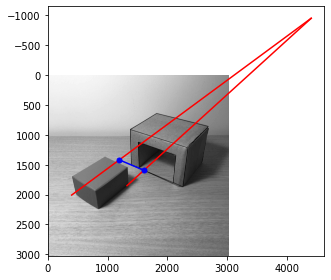

In [32]:
# проверка пройдет ли коробка по ширине
line1 = two_point_to_line(a, d)
line2 = two_point_to_line(w1, F_hor)
line3 = two_point_to_line(w2, F_hor)

p1 = intersect_line_decart(line1, line2)
p2 = intersect_line_decart(line1, line3)
real_dist = get_l2(a1, d1)
dist = get_l2(p1, p2)

if dist >= real_dist:
    print('NO. Не пройдет по ширине')
    ans2 = False
else:
    print('YES. По ширине пройдет')
    ans2 = True

plt.imshow(img_gray, cmap='gray')
plt.plot( [w2[0], F_hor[0]],[w2[1], F_hor[1]], 'r')
plt.plot( [w1[0], F_hor[0]] , [w1[1], F_hor[1]],'r')

plt.plot(  p1[0], p1[1],'ob', markersize=5)
plt.plot(  p2[0], p2[1],'ob', markersize=5)

plt.plot(  [ p1[0],  p2[0]], [ p1[1],  p2[1]],'b')


plt.tight_layout()

In [33]:
ans = ans1 and ans2
if ans:
    print('Коробка пролезет под арку')
else:
    print('Коробка не пролезет под арку')

Коробка пролезет под арку
